## Fine Tuning for Medical Coding

####  Part 2: Fine Tuning

---

**Goal for this Notebook**
- Create a customized fine-tuned version of GPT-4o-mini to act as a L1 (ICD9 Chapter) classifier. This eliminates the 'long tail problem' for a supervised learning approach to classification
- Evaluate the fine-tuned model against a subset of the MIMIC-II dataset

**Approach**  
  
This notebook implements a supervised fine-tuning of OpenAI's gpt-4o-mini small language model. The MIMIC-III data is **_NOT_** used for fine-tuning. The model is trained on ICD9 and UMLS ontology which allows for use of the MIMIC-III data as a pure evaluation (holdout) dataset. This appraoch leverages Azure OpenAI's Fine-Tuning service. [More details on the managed service here.](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning?tabs=turbo%2Cpython-new&pivots=programming-language-python).

**Further Reading**

Most state of the art approached leverage fine-tuning - [read more about them here](https://paperswithcode.com/sota/medical-code-prediction-on-mimic-iii)

In [1]:
from dotenv import load_dotenv, find_dotenv
from openai import AzureOpenAI
from tqdm.notebook import tqdm
import plotly.express as px
import pandas as pd
import numpy as np
import os
import ast

from src.icd9_tree import ICD9

load_dotenv(find_dotenv(), override=True)
pd.set_option('display.max_colwidth', None)

In [2]:
# Establish client to Azure OpenAI

client = AzureOpenAI(
  azure_endpoint = os.getenv("AZURE_OPENAI_BASE"), 
  api_key=os.getenv("AZURE_OPENAI_KEY"),  
  api_version="2024-05-01-preview"
)

In [ ]:
# Init code tree
tree = ICD9('icd9_codes_full.json')
print(len(tree.children))

---
#### Fine-Tune and Deploy Custom Model

In [ ]:
training_file_name = 'data/ft/training_data_L1toL3_multi.jsonl'

# Upload the training and validation dataset files to Azure OpenAI with the SDK.

training_response = client.files.create(
    file=open(training_file_name, "rb"), purpose="fine-tune"
)
training_file_id = training_response.id

print("Training file ID:", training_file_id)

In [ ]:
response = client.fine_tuning.jobs.create(
    training_file=training_file_id,
    model="gpt-4o-mini",
    seed = 123,
    hyperparameters={
    "n_epochs":3 # Start small
  }
)
print(response)

**PAUSE HERE** - Once the Finetuning Job has completed, deploy the fine-tuned model via the Azure OpenAI Studio  

1. Navigate to the Azure OpenAI Studio to deploy the model via the UI  (screenshot below)
2. Populate the "FINE-TUNED" fields in your .env file
  
<small>_Sample Screenshot:_</small>
    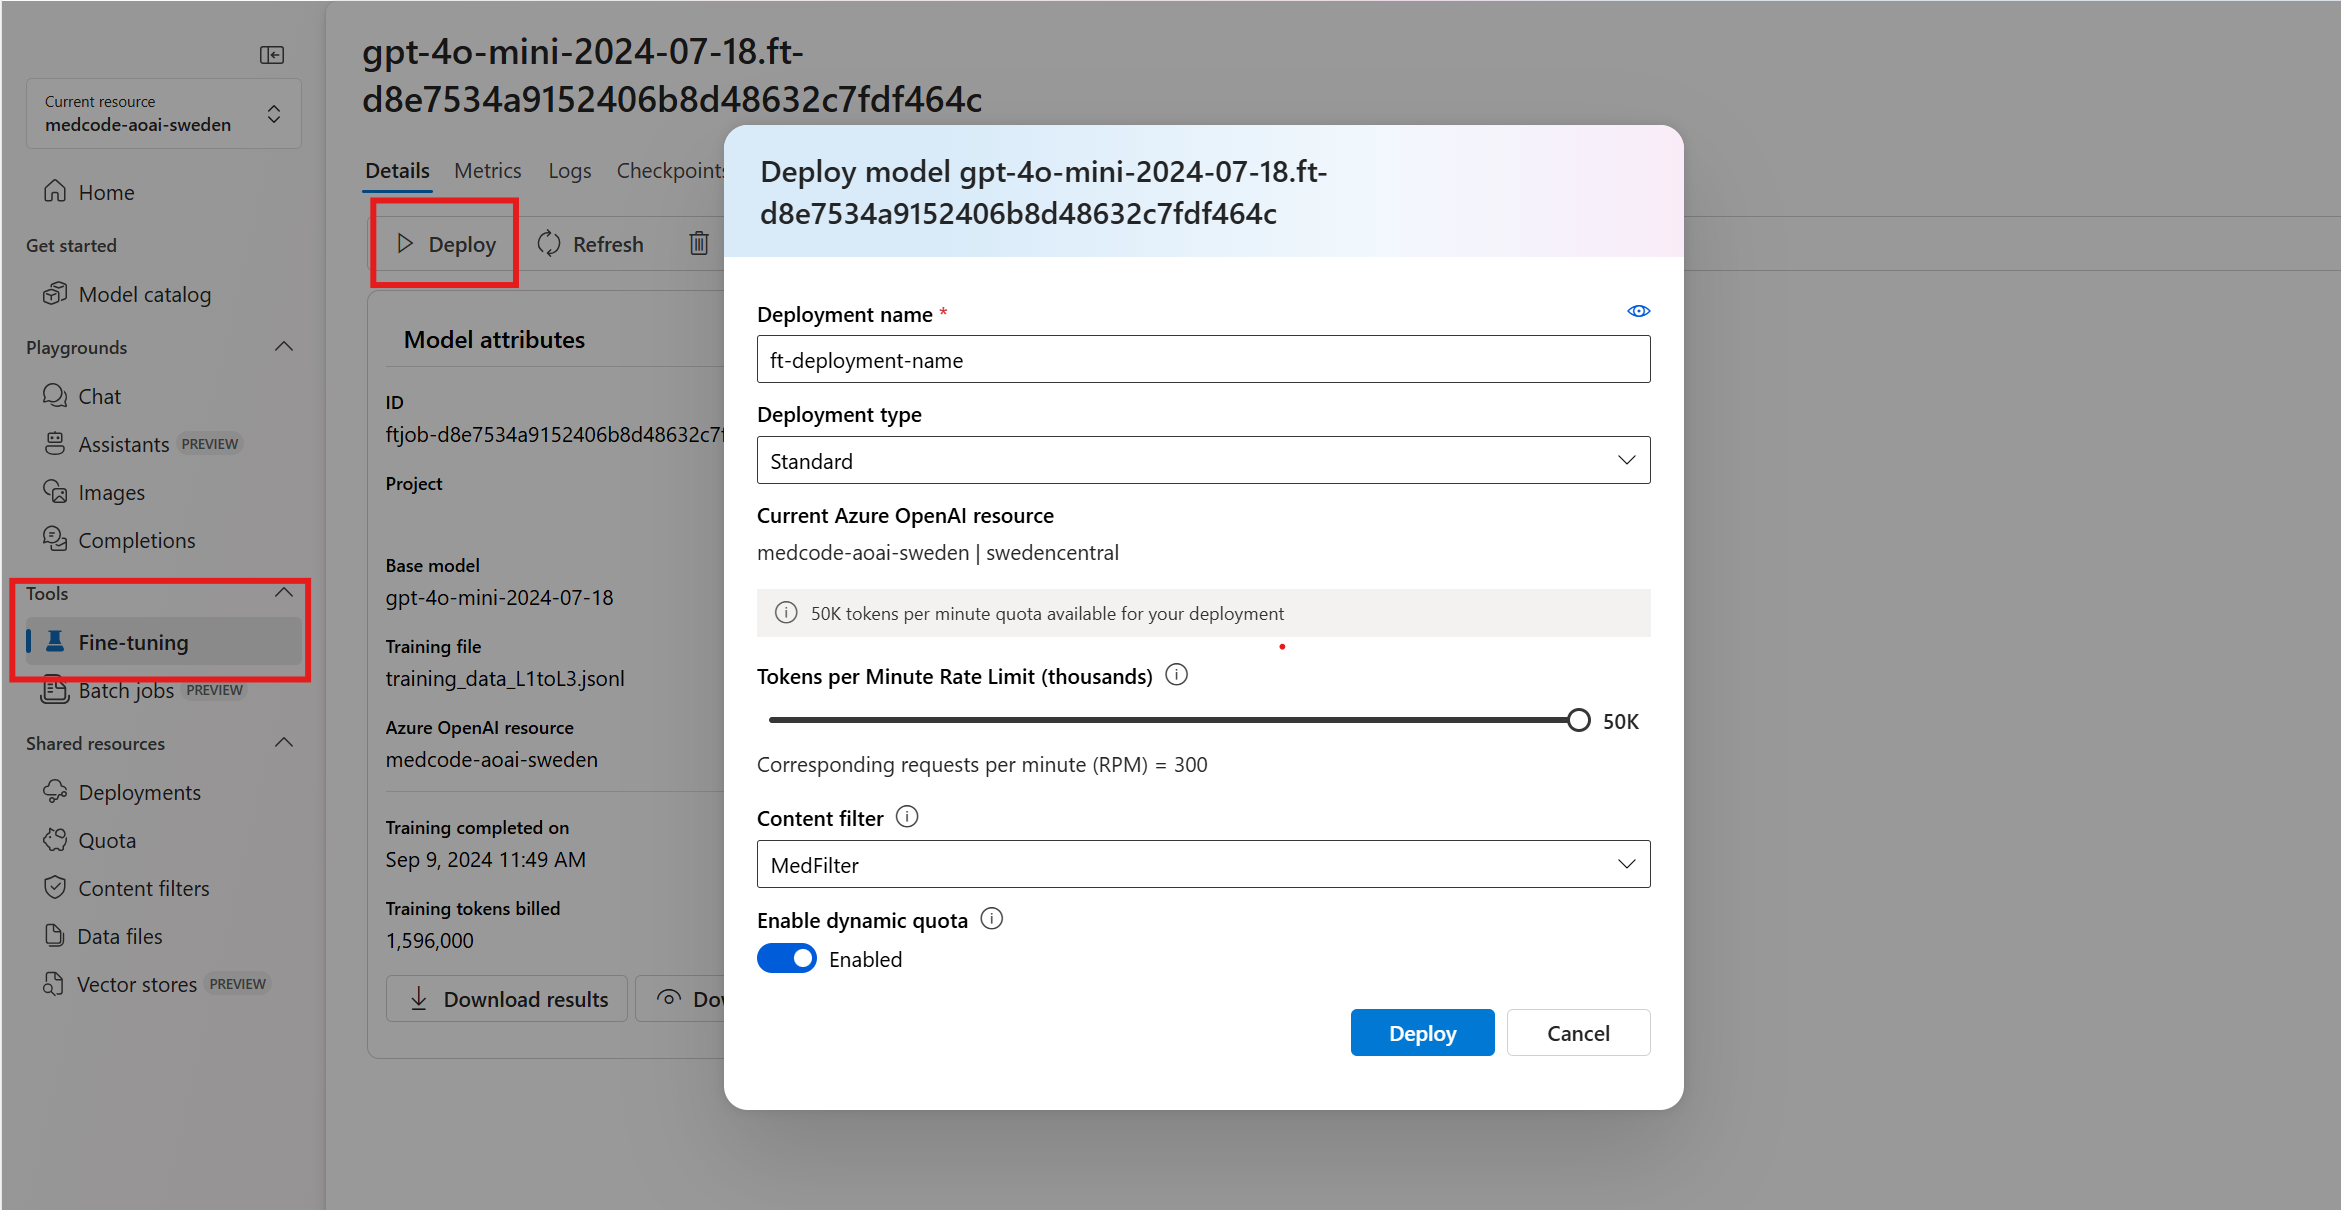



In [4]:
# Establish client to your fine-tuned model
finetuned_client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_BASE"), 
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    api_version="2024-06-01"
)

In [ ]:
# Prepare eval data
mimic_df = pd.read_csv('data/joined/dataset_single_notes_full.csv.gz')
print(f"Total shape: {mimic_df.shape}")
print(mimic_df.dtypes)

# Take a subsample for evaluation
mimic_df = mimic_df.sample(200, replace=False, random_state=123)
display(mimic_df.head(1))

In [6]:
# Evaluation funcitons

def get_chapter_descriptions(chapter_codes):
    description_list = []
    for code in chapter_codes:
        description_list.append(tree.find(code).description.strip())
    return ';'.join(description_list)

def recall_score(truth, generated):
    actual_list = truth.split(';')
    generated_list = generated.split(';')

    similar = len(set(actual_list) & set(generated_list))

    return similar / len(actual_list)

def precision_score(truth, generated):
    actual_list = truth.split(';')
    generated_list = generated.split(';')

    if len(generated) == 0:
        return 0

    similar = len(set(actual_list) & set(generated_list))

    return similar / len(generated_list)

def f1_score(truth, generated):
    precision = precision_score(truth, generated)
    recall = recall_score(truth, generated)

    if precision + recall == 0:
        return 0
    else:
        return 2 * (precision * recall) / (precision + recall)

---
#### Get MIMIC-III Predictions [Multi-Text Label Example]

In [ ]:
### Get AI Predictions
def get_model_completions(client, prompt, deployment, tree):
    """
    This function generates a model completion from a given prompt using the OpenAI API.

    Parameters:
    client (openai.Client): The AzureOpenAI client being used.
    prompt (str): The prompt to be sent to the model for completion.
    deployment (str): The identifier of the model deployment to be used for completion.
    tree (ICD9): The ICD9 tree object to be used for mapping the model completion to a chapter.

    Returns:
    list: A list of tuples containing the ICD9 code chapter and the probability of the completion
    """
    sys = "Classify the following text into an ICD9 code chapter. The text is a clinical note from a patient medical record. ### You must choose from the following semi-colon delimited list of codes:INFECTIOUS AND PARASITIC DISEASES ; NEOPLASMS ; ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS ; DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS ; MENTAL DISORDERS ; DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS ; DISEASES OF THE CIRCULATORY SYSTEM ; DISEASES OF THE RESPIRATORY SYSTEM ; DISEASES OF THE DIGESTIVE SYSTEM ; DISEASES OF THE GENITOURINARY SYSTEM ; COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM ; DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE ; DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE ; CONGENITAL ANOMALIES ; CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD ; SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS ; INJURY AND POISONING  ### RESPOND ONLY WITH A CODES FROM THE LIST ABOVE. IF MULTIPLE CODES USE A SEMI-COLON DELIMITER"
    
    messages = [
        {'role':'system','content':sys},
        {'role':'user','content':prompt}
        ]

    try:
        response = client.chat.completions.create(
            messages=messages,
            model=deployment,
            temperature=0,
        )
        

        return response.choices[0].message.content

    except Exception as e:
        print(e)
        return None
    
## TEST ##
answer = get_model_completions(finetuned_client, "Patient has a history of diabetes and hypertension.", os.getenv("FINE_TUNED_DEPLOYMENT_NAME"), tree)
print(f"Answer: {answer}")

In [ ]:
# Generate Predictions
tqdm.pandas()
mimic_df['chapter_preds'] = mimic_df.progress_apply(lambda x: get_model_completions(finetuned_client, x.TEXT, os.getenv("FINE_TUNED_DEPLOYMENT_NAME"), tree), axis=1)
display(mimic_df[['chapter_codes','chapter_preds']].head(5))

##### Evaluate the Predictions

In [ ]:
# Get Ground Truth Descriptions
mimic_df['ground_truth_desc'] = mimic_df.chapter_codes.apply(lambda x: get_chapter_descriptions(ast.literal_eval(x)))
display(mimic_df[['ground_truth_desc','chapter_preds']].head(5))

In [ ]:
# Results
results_dict = {}
results_dict['recall'] = mimic_df.apply(lambda x: recall_score(x.ground_truth_desc, x.chapter_preds), axis=1).mean()
results_dict['precision'] = mimic_df.apply(lambda x: precision_score(x.ground_truth_desc, x.chapter_preds), axis=1).mean()
results_dict['f1'] = mimic_df.apply(lambda x: f1_score(x.ground_truth_desc, x.chapter_preds), axis=1).mean()

results_df = pd.DataFrame([results_dict])
display(results_df.head(10))

---
#### Get MIMIC-III Predictions [Logits Example]
In some cases, especially for human in the loop, it is important to reveal the top X number of options along with the predicted values. The logprobs parameter allows for visibility into tops options and threshold tuning in these cases. 

In [ ]:
### Get AI Predictions
def get_model_completions_logits(client, prompt, deployment, tree):
    """
    This function generates a model completion from a given prompt using the OpenAI API.

    Parameters:
    client (openai.Client): The AzureOpenAI client being used.
    prompt (str): The prompt to be sent to the model for completion.
    deployment (str): The identifier of the model deployment to be used for completion.
    tree (ICD9): The ICD9 tree object to be used for mapping the model completion to a chapter.

    Returns:
    list: A list of tuples containing the ICD9 code chapter and the probability of the completion
    """
    result_list = []
    chapter_list = ["INFECTIOUS AND PARASITIC DISEASES" , "NEOPLASMS" , "ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS" , "DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS" , "MENTAL DISORDERS" , "DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS" , "DISEASES OF THE CIRCULATORY SYSTEM" , "DISEASES OF THE RESPIRATORY SYSTEM" , "DISEASES OF THE DIGESTIVE SYSTEM" , "DISEASES OF THE GENITOURINARY SYSTEM" , "COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM" ,"DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE" , "DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE" , "CONGENITAL ANOMALIES" , "CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD" , "SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS" , "INJURY AND POISONING"]
    sys = "Classify the following text into an ICD9 code chapter. The text is a clinical note from a patient medical record. ### You must choose from the following semi-colon delimited list of codes:INFECTIOUS AND PARASITIC DISEASES ; NEOPLASMS ; ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS ; DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS ; MENTAL DISORDERS ; DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS ; DISEASES OF THE CIRCULATORY SYSTEM ; DISEASES OF THE RESPIRATORY SYSTEM ; DISEASES OF THE DIGESTIVE SYSTEM ; DISEASES OF THE GENITOURINARY SYSTEM ; COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM ; DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE ; DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE ; CONGENITAL ANOMALIES ; CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD ; SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS ; INJURY AND POISONING  ### RESPOND ONLY WITH A CODES FROM THE LIST ABOVE. IF MULTIPLE CODES USE A SEMI-COLON DELIMITER"
    

    messages = [
        {'role':'system','content':sys},
        {'role':'user','content':prompt}
        ]

    try:
        response = client.chat.completions.create(
            messages=messages,
            model=deployment,
            temperature=0,
            logprobs=True,
            top_logprobs=17 # This can be the total number of classes, or a smaller number
        )
        
        for toplogprob in response.choices[0].logprobs.content[0].top_logprobs:
            try:
                chapter = [s for s in chapter_list if s.startswith(toplogprob.token)]
                result_list.append((chapter[0], np.exp(toplogprob.logprob)*100)) # Convert logprob to probability
            except Exception as e:
                print(f"Warning no parent found for {e}")

        return result_list

    except Exception as e:
        print(e)
        return None
    
## TEST ##
answer = get_model_completions_logits(finetuned_client, "Patient has a history of diabetes and hypertension.", os.getenv("FINE_TUNED_DEPLOYMENT_NAME"), tree)
print(f"Answer: {answer}")

In [ ]:
# Generate Predictions
tqdm.pandas()
mimic_df['chapter_preds'] = mimic_df.progress_apply(lambda x: get_model_completions_logits(finetuned_client, x.TEXT, os.getenv("FINE_TUNED_DEPLOYMENT_NAME"), tree), axis=1)
display(mimic_df[['chapter_codes','chapter_preds']].head(5))

##### Evaluate Prediction Results

In [ ]:
# Get Ground Truth Descriptions
mimic_df['ground_truth_desc'] = mimic_df.chapter_codes.apply(lambda x: get_chapter_descriptions(ast.literal_eval(x)))
display(mimic_df[['ground_truth_desc','chapter_preds']].head(5))

In [14]:
# Extract predictions for each threshold

def get_thresholded_preds(chapter_preds, threshold):
    '''
    chapter preds: list of tuples with chapter and probability
    threshold: float value for threshold probability percentage (1-100)
    '''
    preds_list = [x[0] for x in chapter_preds if x[1] >= threshold]
    return ';'.join(preds_list)

mimic_df['preds_50'] = mimic_df['chapter_preds'].apply(lambda x: get_thresholded_preds(x, 50))
mimic_df['preds_75'] = mimic_df['chapter_preds'].apply(lambda x: get_thresholded_preds(x, 75))
mimic_df['preds_90'] = mimic_df['chapter_preds'].apply(lambda x: get_thresholded_preds(x, 90))
mimic_df['preds_25'] = mimic_df['chapter_preds'].apply(lambda x: get_thresholded_preds(x, 25))
mimic_df['preds_10'] = mimic_df['chapter_preds'].apply(lambda x: get_thresholded_preds(x, 10))
mimic_df['preds_01'] = mimic_df['chapter_preds'].apply(lambda x: get_thresholded_preds(x, 1))
mimic_df['preds_0005'] = mimic_df['chapter_preds'].apply(lambda x: get_thresholded_preds(x, 0.05))

In [ ]:
# Grade Chapter Predictions for each threshold

results_list = []
pred_cols = ['preds_50', 'preds_75', 'preds_90', 'preds_25', 'preds_10', 'preds_01', 'preds_0005']


for col in pred_cols:
    results_dict = {}
    results_dict['name'] = col
    results_dict['recall'] = mimic_df.apply(lambda x: recall_score(x.ground_truth_desc, x[col]), axis=1).mean()
    results_dict['precision'] = mimic_df.apply(lambda x: precision_score(x.ground_truth_desc, x[col]), axis=1).mean()
    results_dict['f1'] = mimic_df.apply(lambda x: f1_score(x.ground_truth_desc, x[col]), axis=1).mean()
    results_list.append(results_dict)

results_df = pd.DataFrame(results_list)
display(results_df.head(10))

In [ ]:
# Plot metrics by threshold
fig = px.bar(results_df, x='name', y=['recall', 'precision', 'f1'], title='Metrics by Threshold', barmode='group')
fig.show()

---
#### Limitations, Challenges, and Next Steps

1. In this notebook, the model exhibits state-of-the-art recall and precision on par with the existing approaches. HOWEVER, this is likely due to the fact that we are not cleaning the messy MIMIC-III notes before sending to the model. Notes likely include irrelevant information - like prior medical history - that the model classifies as an ICD9 code marker. Check out the [second notebook in this repository](./02_llm_extraction.ipynb) to review techiques to simplify MIMIC-III notes 
  
    Note: Most [state of the art approaches](https://paperswithcode.com/sota/medical-code-prediction-on-mimic-iii) often take extreme subsamples of data to limit the problem space.   
  
2. Level 2 (Sub-category) classification is not explored in this notebook. The 'vast label space' problem is much more prevelant (much more than 17 label options). One solution option - train a FT'd model for each sub-category of the ICD9 heirarchy tree.
